In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [5]:
x, y = skds.fetch_openml("MiniBooNE", return_X_y=True)

In [6]:
x.shape

(130064, 50)

In [7]:
y.shape

(130064,)

In [8]:
np.unique(y)

array(['False', 'True'], dtype=object)

In [13]:
x = StandardScaler().fit_transform(x)


In [18]:
x_neg=x[y=='False']
x_pos=x[y=='True']

In [19]:
len(x_neg)

93565

In [20]:
len(x_pos)

36499

In [21]:
np.random.shuffle(x_neg)
x_test=x_neg[0:46782]
x_train=x_neg[46782:130064]
x_train=np.concatenate((x_train,x_pos))

In [22]:
y_train=np.concatenate((np.zeros(46783),np.ones(36499)))
y_test=np.zeros(46782)

# Kraska Model

In [23]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [24]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 10


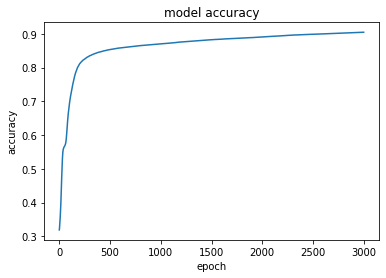

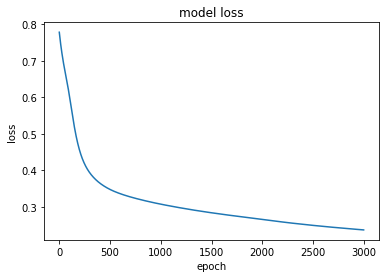

Size: 18340.000000 bits - FPR: 0.846223 



Number of nodes: 12


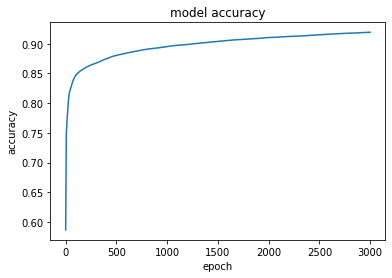

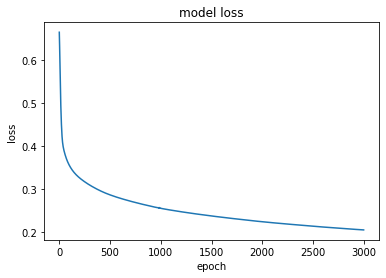

Size: 22001.000000 bits - FPR: 0.920397 



Number of nodes: 14


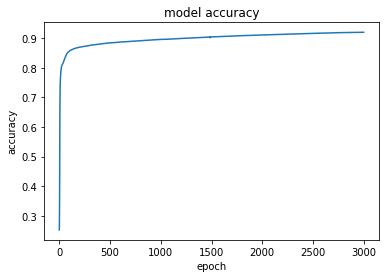

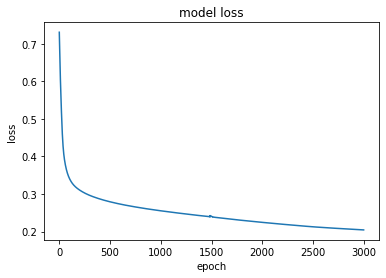

Size: 25661.000000 bits - FPR: 0.824035 



Number of nodes: 16


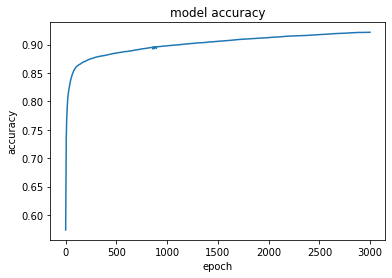

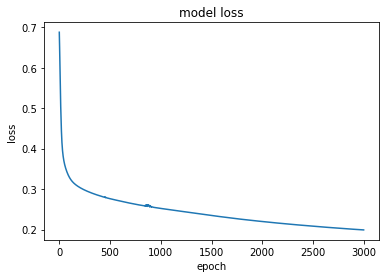

Size: 29322.000000 bits - FPR: 0.844855 



Number of nodes: 18


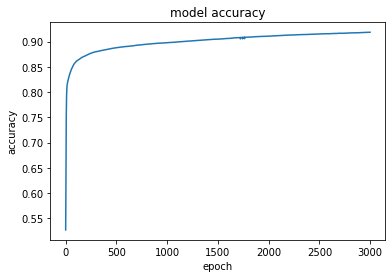

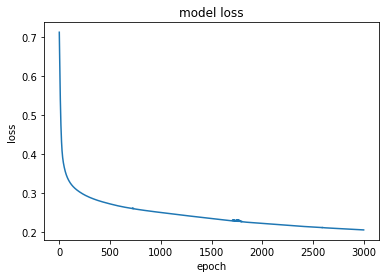

Size: 32983.000000 bits - FPR: 0.776965 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 10


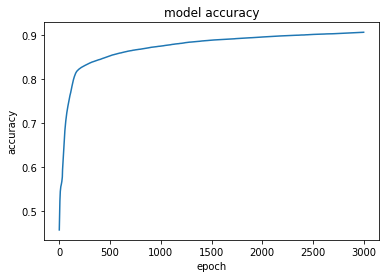

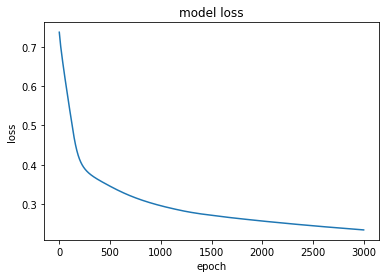

Size: 18340.000000 bits - FPR: 0.906973 



Number of nodes: 12


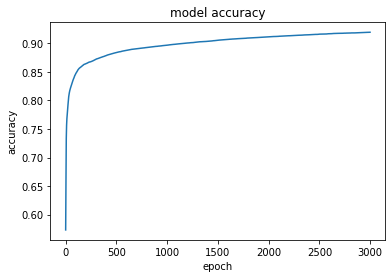

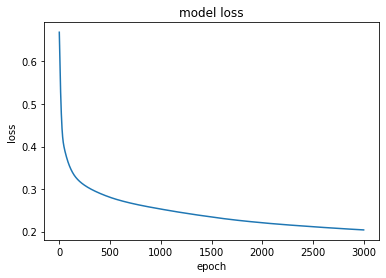

Size: 22001.000000 bits - FPR: 0.913321 



Number of nodes: 14


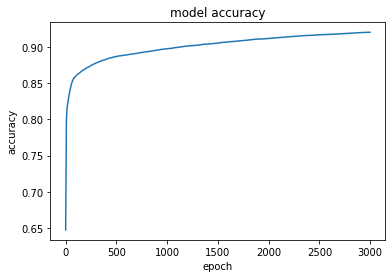

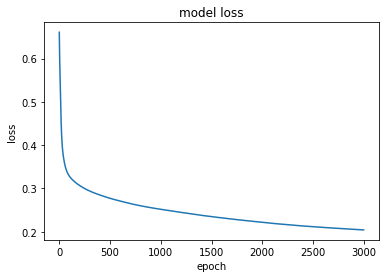

Size: 25661.000000 bits - FPR: 0.852123 



Number of nodes: 16


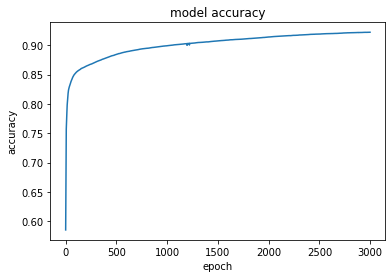

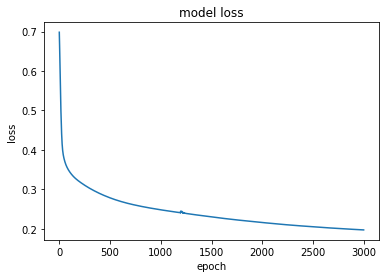

Size: 29322.000000 bits - FPR: 0.824270 



Number of nodes: 18


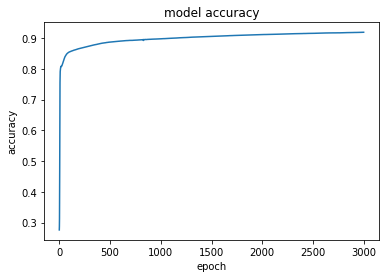

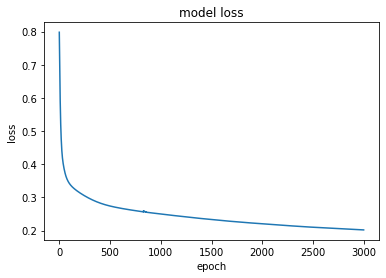

Size: 32983.000000 bits - FPR: 0.709931 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 10


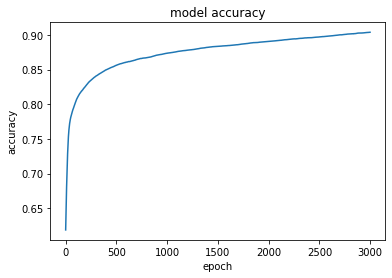

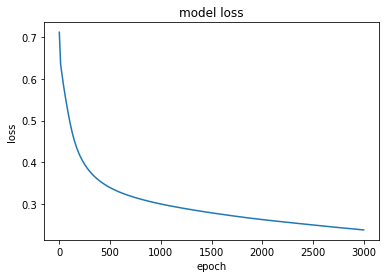

Size: 18340.000000 bits - FPR: 0.924180 



Number of nodes: 12


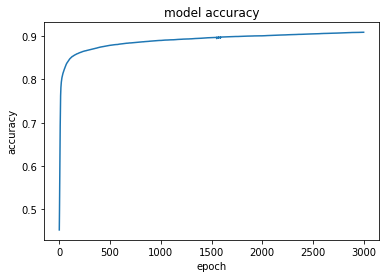

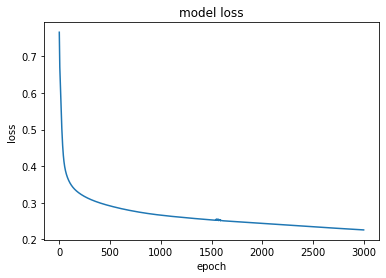

Size: 22001.000000 bits - FPR: 0.882476 



Number of nodes: 14


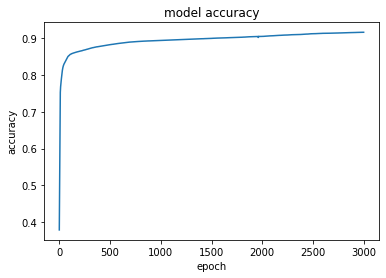

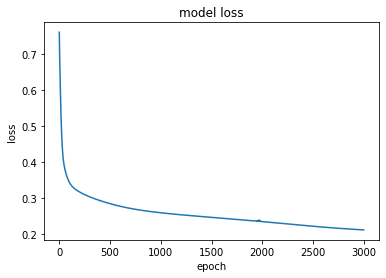

Size: 25661.000000 bits - FPR: 0.828695 



Number of nodes: 16


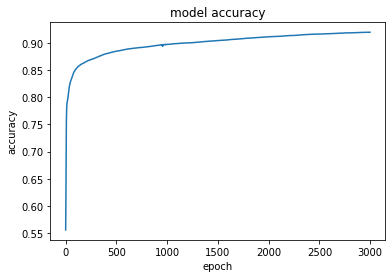

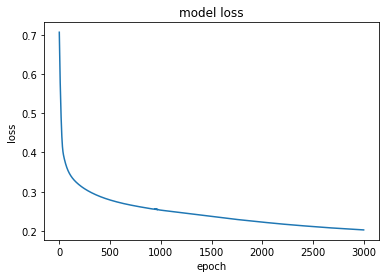

Size: 29322.000000 bits - FPR: 0.795263 



Number of nodes: 18


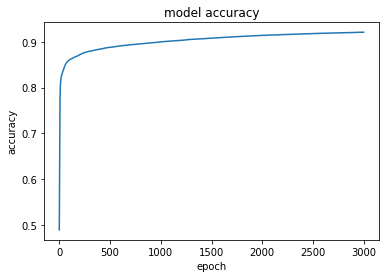

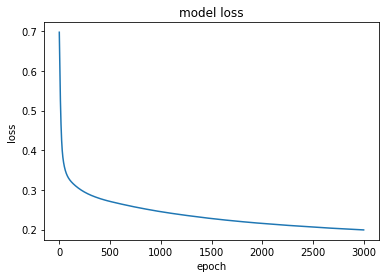

Size: 32983.000000 bits - FPR: 0.725535 





In [26]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,10,2,5,3000,fpr_values_kraska,size_values_kraska)

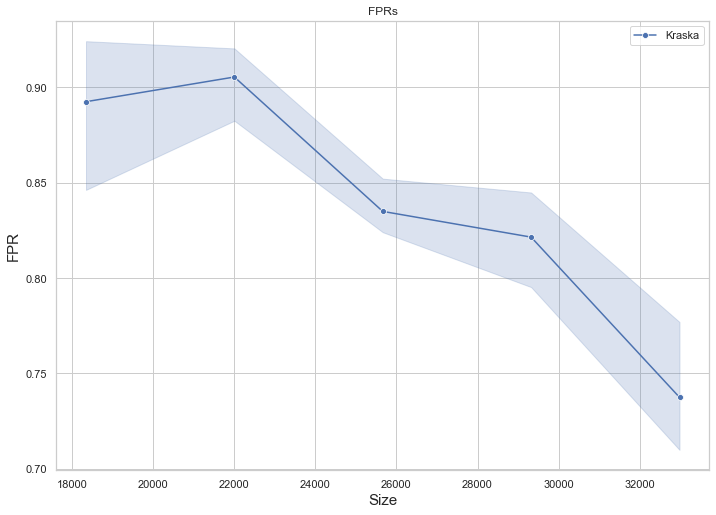

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

 # Projection Model

In [28]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors       
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [29]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [33]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,90000,2000,100,100,fpr_values,size_values)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(36499, 50)
Size: 90000 Bits - FPR: 0.514322 



Size: 92000 Bits - FPR: 0.562481 



Size: 94000 Bits - FPR: 0.574879 



Size: 96000 Bits - FPR: 0.524475 



Size: 98000 Bits - FPR: 0.559360 



Size: 100000 Bits - FPR: 0.459493 



Size: 102000 Bits - FPR: 0.497884 



Size: 104000 Bits - FPR: 0.445214 



Size: 106000 Bits - FPR: 0.545830 



Size: 108000 Bits - FPR: 0.579496 



Size: 110000 Bits - FPR: 0.533047 



Size: 112000 Bits - FPR: 0.586828 



Size: 114000 Bits - FPR: 0.537664 



Size: 116000 Bits - FPR: 0.525010 



Size: 118000 Bits - FPR: 0.513958 



Size: 120000 Bits - FPR: 0.483391 



Size: 122000 Bits - FPR: 0.578855 



Size: 124000 Bits - FPR: 0.537130 



Size: 126000 Bits - FPR: 0.486662 



Size: 128000 Bits - FPR: 0.532748 



Size: 130000 Bits - FPR: 0.541319 



Size: 132000 Bits - FPR: 0.461011 



Size: 134000 Bits - FPR: 0.395280 



Size: 136000 Bits - FPR: 0.399384 



Size: 138000 Bits - FPR: 0.488564 



Size: 14000

Size: 116000 Bits - FPR: 0.526677 



Size: 118000 Bits - FPR: 0.517827 



Size: 120000 Bits - FPR: 0.530674 



Size: 122000 Bits - FPR: 0.452289 



Size: 124000 Bits - FPR: 0.541533 



Size: 126000 Bits - FPR: 0.436899 



Size: 128000 Bits - FPR: 0.541191 



Size: 130000 Bits - FPR: 0.364627 



Size: 132000 Bits - FPR: 0.433671 



Size: 134000 Bits - FPR: 0.424800 



Size: 136000 Bits - FPR: 0.504810 



Size: 138000 Bits - FPR: 0.481553 



Size: 140000 Bits - FPR: 0.496580 



Size: 142000 Bits - FPR: 0.458510 



Size: 144000 Bits - FPR: 0.457655 



Size: 146000 Bits - FPR: 0.474969 



Size: 148000 Bits - FPR: 0.445492 



Size: 150000 Bits - FPR: 0.415117 



Size: 152000 Bits - FPR: 0.420204 



Size: 154000 Bits - FPR: 0.354688 



Size: 156000 Bits - FPR: 0.302296 



Size: 158000 Bits - FPR: 0.505857 



Size: 160000 Bits - FPR: 0.493609 



Size: 162000 Bits - FPR: 0.419178 



Size: 164000 Bits - FPR: 0.471399 



Size: 166000 Bits - FPR: 0.462357 



Size: 168000

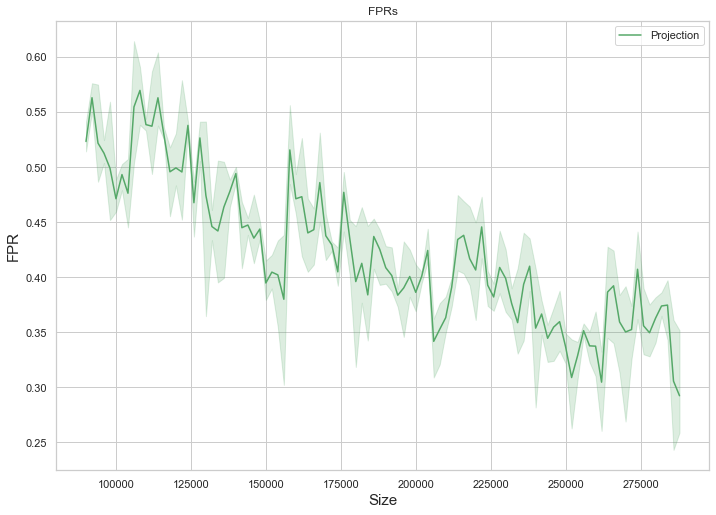

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter

In [35]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [36]:
print(sum(y_train))
print(len(y_train))

36499.0
83282


In [37]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

300
36499.0


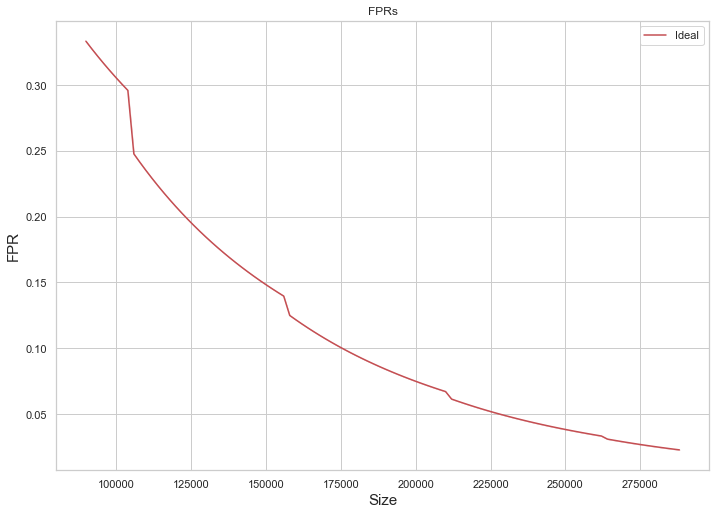

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [39]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Projection FPR,Ideal FPR
0,90000,0.514322,0.333388
1,92000,0.562481,0.327485
2,94000,0.574879,0.321784
3,96000,0.524475,0.316275
4,98000,0.559360,0.310949


In [40]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/MiniBooNe_kernel.csv')

 # FPR Comparison between Projection Model and Normal Bloom Filter

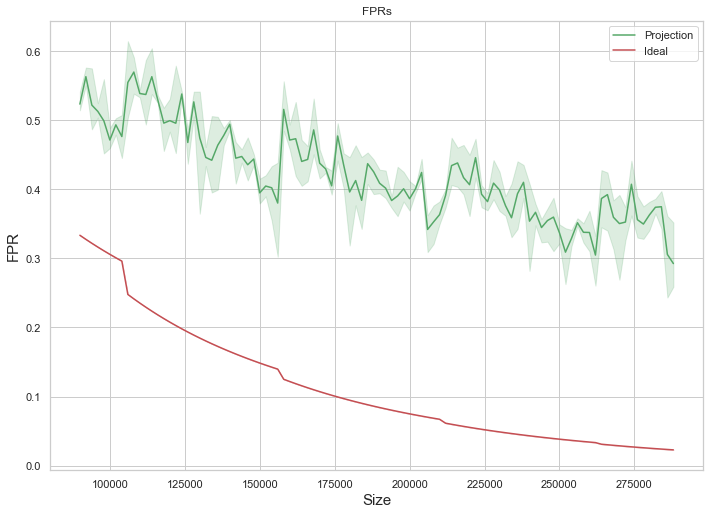

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between all 3 models


In [44]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [45]:
# Ran only once instead of thrice as size_values_kraska already has triple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(36499, 50)
Size: 18340 Bits - FPR: 0.896670 



Size: 22001 Bits - FPR: 0.787204 



Size: 25661 Bits - FPR: 0.834252 



Size: 29322 Bits - FPR: 0.733979 



Size: 32983 Bits - FPR: 0.821897 



Size: 18340 Bits - FPR: 0.917426 



Size: 22001 Bits - FPR: 0.883823 



Size: 25661 Bits - FPR: 0.833889 



Size: 29322 Bits - FPR: 0.752661 



Size: 32983 Bits - FPR: 0.746655 



Size: 18340 Bits - FPR: 0.904044 



Size: 22001 Bits - FPR: 0.862917 



Size: 25661 Bits - FPR: 0.854773 



Size: 29322 Bits - FPR: 0.805609 



Size: 32983 Bits - FPR: 0.749348 





In [46]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

15
36499.0


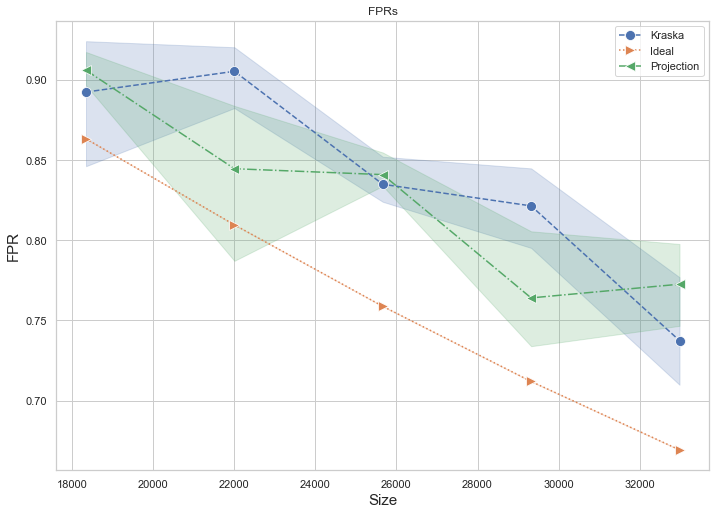

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [48]:
saved_data = list(zip(size_values_kraska, fpr_values_kraska,fpr_values_projection, y_ideal_k))
df = pd.DataFrame(saved_data,columns = ['Size','Kraska FPR', 'Projection FPR', 'Ideal FPR'])
df.head()

,Size,Kraska FPR,Projection FPR,Ideal FPR
0,18340,0.846223,0.896670,0.863330
1,22001,0.920397,0.787204,0.809672
2,25661,0.824035,0.834252,0.758861
3,29322,0.844855,0.733979,0.711998
4,32983,0.776965,0.821897,0.669324


In [49]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/MiniBooNe_kernel_kraska.csv')